In [1]:
%load_ext autoreload


In [2]:
%autoreload 2
import time
import numpy as np
import matplotlib.pyplot as plt
from minopy.lib.utils import est_corr_py
import minopy.simulation as mnp
from skimage.measure import label
import pandas as pd
from scipy import linalg as LA
from minopy.lib.utils import sequential_phase_linking_py, phase_linking_process_py, datum_connect_py
import matplotlib.colors as mcolors
from scipy.linalg import lapack as lap


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

In [3]:
## velocity 4 mm/y

lamda = 56.0 #wavelength (mm)
n_img = 100
n_shp = 300
velocity = 4 #mm/y
velocity_fading = 0 #mm/y      # no fading signal
tmp_bl = 6 #days

vel_phase = velocity/365*4*np.pi/lamda    #0.0024 # rad/day
decorr_days = 50
decorr_days_seasonal = 400

vel_fading = velocity_fading/365*4*np.pi/lamda  # 0.031 # rad/day
decorr_days_fading = 11

gamma0 = 0.6
gammaf_decor = 0
gammaf_cor = 0.1
gamma_fading = 0.18   



center = 0
divnorm = mcolors.TwoSlopeNorm(vmin=0,vcenter=0.3, vmax=1)
hex_list = ['#7B0099','#DF2A8E','#ff7b25', '#ffcc5c', '#ffeead']
cmapc=get_continuous_cmap(hex_list)
normc=divnorm

out_dir = './out_figures'

In [4]:
def custom_cmap(vmin=0, vmax=1):
    """ create a custom colormap based on visible portion of electromagnetive wave."""

    from minopy.spectrumRGB import rgb
    rgb = rgb()
    import matplotlib as mpl
    cmap = mpl.colors.ListedColormap(rgb)
    norm = mpl.colors.Normalize(vmin, vmax)

    return cmap, norm


In [6]:
## seasonal
temp_baseline = np.ogrid[0:(tmp_bl * n_img):tmp_bl]

coh_sim_S_s = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_decor, gamma_fading, 
                                                        vel_phase, decorr_days_seasonal, 
                                                        vel_fading, decorr_days_fading, seasonal=True)
coh_sim_L_s = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_cor, gamma_fading, 
                                                        vel_phase, decorr_days_seasonal, 
                                                        vel_fading, decorr_days_fading, seasonal=True)


CCGsam_Sterm_s = mnp.simulate_neighborhood_stack(coh_sim_S_s, neighborSamples=n_shp)
CCGsam_Lterm_s = mnp.simulate_neighborhood_stack(coh_sim_L_s, neighborSamples=n_shp)

coh_est_S_s = np.array(est_corr_py(CCGsam_Sterm_s))
coh_est_L_s = np.array(est_corr_py(CCGsam_Lterm_s))

cov_S_s = mnp.CRLB_cov(coh_sim_S_s, n_shp)
cov_L_s = mnp.CRLB_cov(coh_sim_L_s, n_shp)

crl_S_s = np.hstack([0, np.sqrt(np.diag(cov_S_s))])
crl_L_s = np.hstack([0, np.sqrt(np.diag(cov_L_s))])

## no seasonal

coh_sim_S = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_decor, gamma_fading, vel_phase, decorr_days, 
                                                        vel_fading, decorr_days_fading, seasonal=False)
coh_sim_L = mnp.simulate_coherence_matrix_exponential(temp_baseline, gamma0, gammaf_cor, gamma_fading, vel_phase, decorr_days, 
                                                        vel_fading, decorr_days_fading, seasonal=False)

CCGsam_Sterm = mnp.simulate_neighborhood_stack(coh_sim_S, neighborSamples=n_shp)
CCGsam_Lterm = mnp.simulate_neighborhood_stack(coh_sim_L, neighborSamples=n_shp)

coh_est_S = np.array(est_corr_py(CCGsam_Sterm))
coh_est_L = np.array(est_corr_py(CCGsam_Lterm))


cov_S = mnp.CRLB_cov(coh_sim_S, n_shp)
cov_L = mnp.CRLB_cov(coh_sim_L, n_shp)
crl_S = np.hstack([0,np.sqrt(np.diag(cov_S))])
crl_L = np.hstack([0,np.sqrt(np.diag(cov_L))])


0.3872983342343151 0.3872983350071682
0.5454122176291344 0.22918445161234902


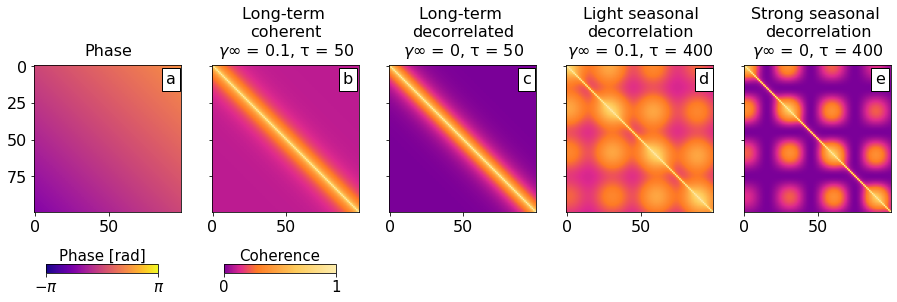

In [7]:
plt.rcParams["font.size"] = "16"
fig9 = plt.figure(figsize=(13, 12), constrained_layout=False)
gs1 = fig9.add_gridspec(nrows=1, ncols=5, left=0.05, right=0.98, top=0.98, bottom=0.81,
                        hspace=0.2, wspace=0.1)

ax1 = fig9.add_subplot(gs1[0,0])
ax2 = fig9.add_subplot(gs1[0,1])
ax3 = fig9.add_subplot(gs1[0,2])
ax4 = fig9.add_subplot(gs1[0,3])
ax5 = fig9.add_subplot(gs1[0,4])

cmap, norm = custom_cmap(-np.pi,np.pi)
im1=ax1.imshow(np.angle(coh_sim_S), cmap='plasma', norm=norm)

cmap, norm = custom_cmap()
im2=ax3.imshow(np.abs(coh_sim_S), cmap=cmapc, norm=normc)
ax2.imshow(np.abs(coh_sim_L), cmap=cmapc, norm=normc)
ax5.imshow(np.abs(coh_sim_S_s), cmap=cmapc, norm=normc)
ax4.imshow(np.abs(coh_sim_L_s), cmap=cmapc, norm=normc)


#plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
#plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
#plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)
#plt.setp(ax5.get_xticklabels(), visible=False)

tau = "τ"

ax1.text(50,-10,'Phase', horizontalalignment='center', verticalalignment='center')
ax2.text(50,-22,'Long-term \ncoherent\n$\gamma$'+u"\u221e = 0.1, {} = 50".format(tau), horizontalalignment='center', verticalalignment='center')
ax3.text(50,-22,'Long-term \ndecorrelated\n$\gamma$'+u"\u221e = 0, {} = 50".format(tau), horizontalalignment='center', verticalalignment='center')
ax4.text(50,-22,'Light seasonal\ndecorrelation\n$\gamma$'+u"\u221e = 0.1, {} = 400".format(tau) , horizontalalignment='center', verticalalignment='center')
ax5.text(50,-22,'Strong seasonal \ndecorrelation\n$\gamma$'+u"\u221e = 0, {} = 400".format(tau), horizontalalignment='center', verticalalignment='center')



cax = fig9.add_axes([0.26, 0.74, 0.12, 0.01])
cbar = plt.colorbar(im2, cax=cax, ticks=[0,1], orientation='horizontal')
cbar.set_label('Coherence', fontsize=15,color = "black")
cbar.ax.set_xticklabels([r'0', r'1'], fontsize=15)
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.xaxis.set_tick_params(color='black')
cbar.outline.set_edgecolor('black')
plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='black')

cax = fig9.add_axes([0.07, 0.74, 0.12, 0.01])
cbar = plt.colorbar(im1, cax=cax, ticks=[-np.pi, np.pi], orientation='horizontal')
cbar.set_label('Phase [rad]', fontsize=15,color = "black")
cbar.ax.set_xticklabels([r'$-\pi$',r'$\pi$'], fontsize=15)
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.xaxis.set_tick_params(color='black')
cbar.outline.set_edgecolor('black')
plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='black')


ax1.text(92.5,9,'a', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax2.text(92,9,'b', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax3.text(93,9,'c', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax4.text(93,9,'d', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax5.text(92.5,9,'e', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))

plt.savefig(out_dir + '/coh_matrix_simulation.png', bbox_inches='tight', transparent=True, dpi=300)


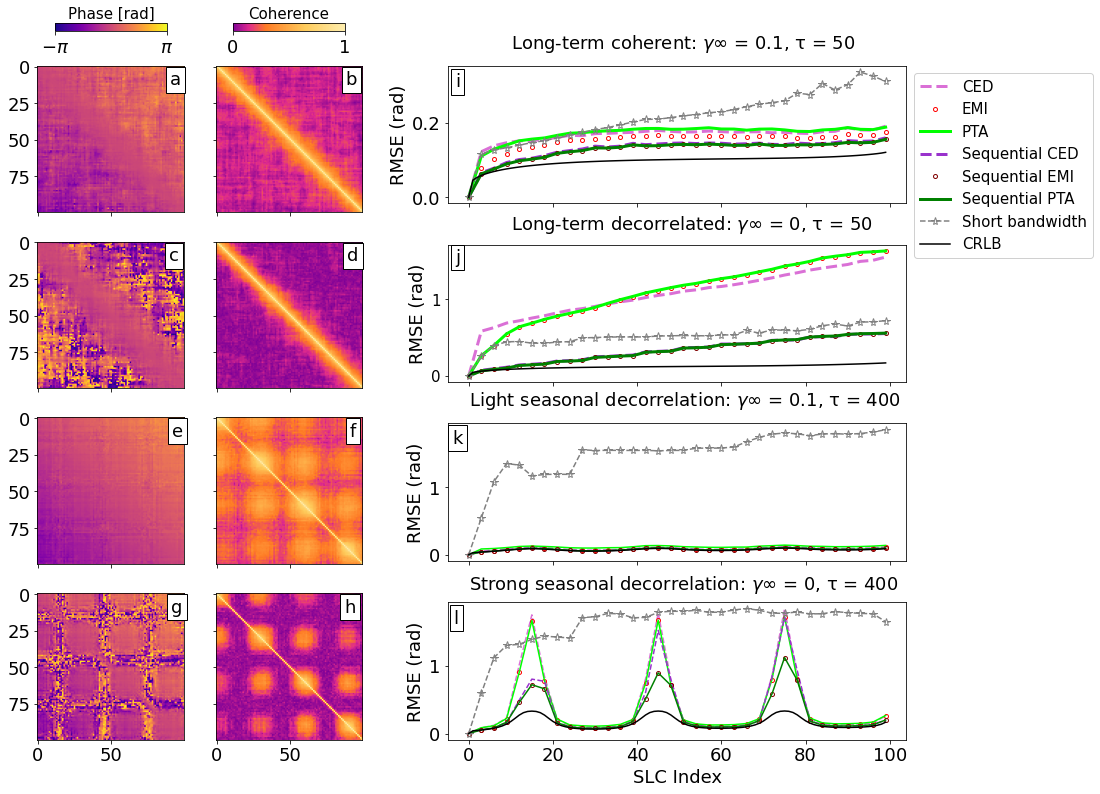

In [8]:
plt.rcParams["font.size"] = "18"
tau = "τ"

fig9 = plt.figure(figsize=(13, 12), constrained_layout=False)

gs2 = fig9.add_gridspec(nrows=4, ncols=2, left=0.05, right=0.40, top=0.98, bottom=0.2,
                        hspace=0.2, wspace=0.2)

ax6 = fig9.add_subplot(gs2[0,0])
ax7 = fig9.add_subplot(gs2[0,1])
ax8 = fig9.add_subplot(gs2[1,0])
ax9 = fig9.add_subplot(gs2[1,1])
ax10 = fig9.add_subplot(gs2[2,0])
ax11 = fig9.add_subplot(gs2[2,1])
ax12 = fig9.add_subplot(gs2[3,0])
ax13 = fig9.add_subplot(gs2[3,1])

gs3 = fig9.add_gridspec(nrows=4, ncols=1, left=0.49, right=0.98, top=0.98, bottom=0.2,
                        hspace=0.3, wspace=0.2)

ax14 = fig9.add_subplot(gs3[0,0])
ax15 = fig9.add_subplot(gs3[1,0])
ax16 = fig9.add_subplot(gs3[2,0])
ax17 = fig9.add_subplot(gs3[3,0])


cmap, norm = custom_cmap(-np.pi,np.pi)
im1=ax8.imshow(np.angle(coh_est_S), cmap='plasma', norm=norm)
ax6.imshow(np.angle(coh_est_L), cmap='plasma', norm=norm)
ax12.imshow(np.angle(coh_est_S_s), cmap='plasma', norm=norm)
ax10.imshow(np.angle(coh_est_L_s), cmap='plasma', norm=norm)

cmap, norm = custom_cmap()

im2=ax9.imshow(np.abs(coh_est_S), cmap=cmapc, norm=normc)
ax7.imshow(np.abs(coh_est_L), cmap=cmapc, norm=normc)
ax13.imshow(np.abs(coh_est_S_s), cmap=cmapc, norm=normc)
ax11.imshow(np.abs(coh_est_L_s), cmap=cmapc, norm=normc)


rangelim = 6
colors = ['orchid','red','lime','darkorchid','maroon','green','gray']
linestyl = ['s-','x-','^-','s-','x-','^-', 'o-']
linestyl = ['--','.','-','--','.','-', '*--']

markersizzzz=8
markersize=18


rmsemat_est = np.load('./simulation_nof/rmsemat_modifiedSignalEq_linear.npy')


for t in range(rangelim):
    ax14.plot(np.ogrid[0:n_img:3],rmsemat_est[0::3,2*t+1],linestyl[t],color=colors[t], 
              markersize=markersizzzz, markerfacecolor='None', linewidth=3)
ax14.plot(np.ogrid[0:n_img:3],rmsemat_est[0::3,13], linestyl[6],color=colors[6], 
          markersize=markersizzzz, markerfacecolor='None')
ax14.plot(crl_L,'k-', markersize=markersize)
ax14.set_ylabel('RMSE (rad)')
ax14.set_xticklabels([])


for t in range(rangelim):
    ax15.plot(np.ogrid[0:n_img:3],rmsemat_est[0::3,2*t],linestyl[t],color=colors[t], 
              markersize=markersizzzz, markerfacecolor='None', linewidth=3)
ax15.plot(np.ogrid[0:n_img:3],rmsemat_est[0::3,12], linestyl[6],color=colors[6], 
          markersize=markersizzzz, markerfacecolor='None')
ax15.plot(crl_S,'k-', markersize=markersize)
ax15.set_ylabel('RMSE (rad)')
for tick in ax15.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax15.yaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
ax15.set_xticklabels([])



rmsemat_est = np.load('./simulation_nof/rmsemat_modifiedSignalEq_linear_seasonal.npy')



for t in range(rangelim):
    ax16.plot(np.ogrid[0:n_img:3],rmsemat_est[0::3,2*t+1],linestyl[t],color=colors[t], 
              markersize=markersizzzz, markerfacecolor='None')
ax16.plot(np.ogrid[0:n_img:3],rmsemat_est[0::3,13], linestyl[6],color=colors[6], 
          markersize=markersizzzz, markerfacecolor='None')
ax16.plot(crl_L_s,'k-', markersize=markersize)
#ax16.set_xlabel('SLC Index')
ax16.set_ylabel('RMSE (rad)')
ax16.set_xticklabels([])

for t in range(rangelim):
    ax17.plot(np.ogrid[0:n_img:3],rmsemat_est[0::3,2*t],linestyl[t],color=colors[t], 
              markersize=markersizzzz, markerfacecolor='None')
ax17.plot(np.ogrid[0:n_img:3],rmsemat_est[0::3,12], linestyl[6],color=colors[6], 
          markersize=markersizzzz, markerfacecolor='None')
ax17.plot(crl_S_s,'k-', markersize=markersize)
ax17.set_ylabel('RMSE (rad)')

ax17.set_xlabel('SLC Index')





ax14.legend(('CED','EMI','PTA','Sequential CED','Sequential EMI','Sequential PTA', 'Short bandwidth', 'CRLB'),
              loc='upper left', bbox_to_anchor=(1, 1), fontsize=15, framealpha=0.9)



plt.setp(ax6.get_xticklabels(), visible=False)
plt.setp(ax7.get_xticklabels(), visible=False)
plt.setp(ax7.get_yticklabels(), visible=False)
plt.setp(ax8.get_xticklabels(), visible=False)
plt.setp(ax9.get_xticklabels(), visible=False)
plt.setp(ax9.get_yticklabels(), visible=False)
plt.setp(ax10.get_xticklabels(), visible=False)
plt.setp(ax11.get_xticklabels(), visible=False)
plt.setp(ax11.get_yticklabels(), visible=False)
plt.setp(ax13.get_yticklabels(), visible=False)



cax = fig9.add_axes([0.26, 1.02, 0.12, 0.01])
cbar = plt.colorbar(im2, cax=cax, ticks=[0,1], orientation='horizontal')
cbar.set_label('Coherence', fontsize=15,color = "black")
cbar.ax.set_xticklabels([r'0', r'1'])
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.xaxis.set_tick_params(color='black')
cbar.outline.set_edgecolor('black')
plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='black')

cax = fig9.add_axes([0.07,1.02, 0.12, 0.01])
cbar = plt.colorbar(im1, cax=cax, ticks=[-np.pi, np.pi], orientation='horizontal')
cbar.set_label('Phase [rad]', fontsize=15,color = "black")
cbar.ax.set_xticklabels([r'$-\pi$',r'$\pi$'])
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.xaxis.set_tick_params(color='black')
cbar.outline.set_edgecolor('black')
plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='black')



ax6.text(94,9,'a', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax7.text(92,9,'b', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax8.text(93,9,'c', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax9.text(93,9,'d', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax10.text(95,9,'e', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax11.text(93,9,'f', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax12.text(95,9,'g', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax13.text(91,9,'h', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax14.text(-2.56,0.31,'i', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax15.text(-2.63,1.54,'j', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax16.text(-2.63,1.725,'k', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))
ax17.text(-3,1.7,'l', horizontalalignment='center', verticalalignment='center', 
         bbox=dict(facecolor='white', alpha=1))

ax14.text(10, 0.4, 'Long-term coherent: $\gamma$'+u"\u221e = 0.1, {} = 50".format(tau))
ax15.text(10, 1.9, 'Long-term decorrelated: $\gamma$'+u"\u221e = 0, {} = 50".format(tau))
ax16.text(0, 2.2, 'Light seasonal decorrelation: $\gamma$'+u"\u221e = 0.1, {} = 400".format(tau))
ax17.text(0, 2.12, 'Strong seasonal decorrelation: $\gamma$'+u"\u221e = 0, {} = 400".format(tau))

plt.savefig(out_dir + '/coh_matrix_nof.png', bbox_inches='tight', transparent=True, dpi=300)
